# STACKED ENSEMBLING IMPLEMENTATION FOR CLASSIFICATION
_Implements a stacked ensembling for classification on an appropriate dataset._

In [54]:
# Imports required modules and methods

import numpy as np

from sklearn.datasets import make_moons

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt

## The Data
This experiments uses relatively simple binary classification dataset generated synthetically.

In [55]:
# Generates 2D dataset that makes two interleaving half circles
X_moon, y_moon = make_moons(n_samples=1000, noise=0.30, random_state=42)

# Checks the shape of the generated data
X_moon.shape

(1000, 2)

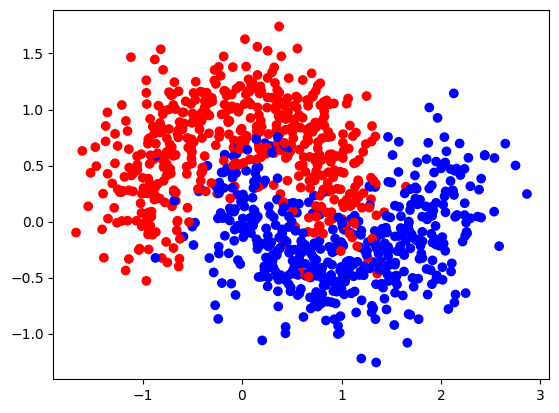

In [56]:
# Visualizes the data to realize the class distribution
plt.scatter(
    X_moon[:,0], X_moon[:,1], 
    c=list(map(lambda x: "red" if x == 0 else "blue", y_moon))  # "red" and "blue" represent class 0 and 1, respectively
)

## Data Preparation

In [57]:
# Splits the dataset into train and test set with stratification
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, test_size=0.2, random_state=42, stratify=y_moon)

## Modeling

### The Estimators

In [58]:
# Initializes the individual classifiers
estimators = [
    ("lr_clf", LogisticRegression(random_state=42)),
    ("rf_clf", RandomForestClassifier(random_state=42)),
    ("svm_clf", SVC(probability=True, random_state=42))
]

In [59]:
# To compare the performance of stacked emsemble, a voting classifier's 
# performance was recorded as reference
voting_clf = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)

# Checks for the CV score of the voting classifier,
print("Voting Classifier's CV Score: {:.3f}".format(
    cross_val_score(voting_clf, X_train, y_train, cv=5, n_jobs=-1).mean()))

# and then checks for the Test set performance
voting_clf.fit(X_train, y_train)
print("Voting Classifier's Test Score: {:.3f}".format(voting_clf.score(X_test, y_test)))

Voting Classifier's CV Score: 0.910
Voting Classifier's Test Score: 0.945


### The Blender

The blender gets trained on the cross-validation predictions made by the estimators and with the train set labels as targets. During inference, estimators first predict on the test set and then the blender take these predictions as input and produces the final prediction.

**Preparing Cross-Validation Predictions**

In [60]:
# Creates space (numpy array) to store CV predictions from all the estimators
estimators_predictions_cv = np.empty(
    shape=(X_train.shape[0], len(estimators)),  # of shape [no. of train examples x no. of estimators 
    dtype=object)

# Verifies the shape of the newly created array to store CV predictions
estimators_predictions_cv.shape

(800, 3)

In [61]:
# Enumerates each estimator
for idx, estimator in enumerate(estimators):
    # For each estimator, performs cross validation predictions on train set
    # and stacks predictions horizontally
    estimators_predictions_cv[:, idx] = cross_val_predict(estimator[1], X_train, y_train, method="predict")

In [62]:
# Shows the few CV predictions for reference
estimators_predictions_cv

array([[1, 1, 1],
       [0, 0, 0],
       [1, 1, 1],
       ...,
       [1, 0, 0],
       [0, 0, 0],
       [1, 1, 1]], dtype=object)

**Blender's Cross-validation Performance**

In [63]:
# Initializes random forest classifier as the blender
blender = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=42)

In [64]:
# Calculates blender's CV Score (on already generated CV prediction dataset by estimators)
print("Blender's CV Score: {:.3f}".format(
    cross_val_score(blender, estimators_predictions_cv, y_train, cv=5).mean()))

Blender's CV Score: 0.903


The above CV score of the blender is nearly same as CV score of the estimators, but couldn't outperform them.

**Blender's Performance on Test Set**

In [65]:
# First, trains the blender on the CV predictions generated by estimators on train set
blender.fit(estimators_predictions_cv, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [66]:
# Creates space (numpy array) to store predictions from all the estimators on the test set
estimators_predictions_test = np.empty(shape=(X_test.shape[0], len(estimators)), dtype=object)

# Verifies the shape of the newly created array to store test predictions
estimators_predictions_test.shape

(200, 3)

In [67]:
# Now, before estimators performs predictions to be input to blender
# for final predictions, they need to be trained first.
for estimator in estimators:
    estimator[1].fit(X_train, y_train)

In [68]:
# Enumerates each estimator
for idx, estimator in enumerate(estimators):
    # For each estimator, performs predictions on the test set
    # and stacks predictions horizontally
    estimators_predictions_test[:, idx] = estimator[1].predict(X_test)

In [69]:
# Shows the few test predictions for reference
estimators_predictions_test[:10]

array([[1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0]], dtype=object)

In [70]:
# The above test predictions made by estimators are then input to blender to make final predictions
blender_predictions = blender.predict(estimators_predictions_test)

In [71]:
# Finally, evaluates the test performance of the blender on predictions made by estimators on the test data
print("Stacked Ensembling Performance: {} [TEST SET]".format(accuracy_score(blender_predictions, y_test)))

Stacked Ensembling Performance: 0.96 [TEST SET]


The test accuracy of the blender of the above stacked ensemble was found to be 96% where it was 94.5% by a relatively simpler voting classifier.